# Singapore Spa Analysis - IBM Capstone Project

## Packages to install each time

In [1]:
import numpy as np
from bs4 import BeautifulSoup
import urllib.request
import urllib
import requests
import pandas as pd
import json
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
from sklearn.cluster import KMeans
# Matplotlib and associated plotting modules
%matplotlib inline 
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
import geopy

### PIPs...

In [2]:
!pip install --user folium

     |████████████████████████████████| 102kB 15.1MB/s ta 0:00:01


In [3]:
import folium

In [4]:
!pip install --user geopandas

     |████████████████████████████████| 972kB 14.1MB/s eta 0:00:01
     |████████████████████████████████| 6.5MB 28.3MB/s eta 0:00:01
     |████████████████████████████████| 14.8MB 35.6MB/s eta 0:00:01
     |████████████████████████████████| 1.0MB 32.2MB/s eta 0:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [5]:
import geopandas as gpd
import fiona

### Get Singapore districts and geo data - from internet source

In [6]:
# SG districts and coordinates

import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.

#### CREDENTIALS REMOVED)

# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

districtsgeo = pd.read_csv(body)
districtsgeo.head()

,District,Latitude,Longitude
0,Ang Mo Kio,1.3691,103.8454
1,Bedok,1.3236,103.9273
2,Bishan,1.3526,103.8352
3,Bukit Batok,1.3590,103.7637
4,Bukit Merah,1.2819,103.8239


In [7]:
# Get main coordinates of Singapore
address = 'Singapore'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

# create map of Singapore using latitude and longitude values
map_sg = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for Latitude, Longitude, District in zip(districtsgeo['Latitude'], districtsgeo['Longitude'], districtsgeo['District']):
    label = '{}'.format(District)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [Latitude, Longitude],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_sg)  

print('The geograpical coordinates of Singapore are {}, {}.'.format(latitude, longitude))    
map_sg

The geograpical coordinates of Singapore are 1.357107, 103.8194992.


In [8]:
#get list of foursquare categories to map to useful / relevant


# Get main coordinates of Singapore
address = 'Singapore'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

# limit of number of venues returned by Foursquare API

#### CREDENTIALS REMOVED

VERSION = '20200719'
LIMIT = 100000 
radius = 1000

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude,
    radius,
    LIMIT)


results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '6017d00f91b0be0bb728bcde'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Bishan',
  'headerFullLocation': 'Bishan, Singapore',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 17,
  'suggestedBounds': {'ne': {'lat': 1.3661070090000091,
    'lng': 103.82848492544791},
   'sw': {'lat': 1.348106990999991, 'lng': 103.81051347455208}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4e1838aa14957dc705d4d8ab',
       'name': 'SICC The Lookout',
       'location': {'address': 'Singapore Island Country Club (Island Location)',
        'crossStreet': 'Island Club Rd.',
        'lat': 1.3591051105392742,
        'lng': 103.8185982847078

In [9]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# ---------

# assume that 5km between districts. Setting up function

def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District',
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

# -----------

# run function

sg_venues = getNearbyVenues(names=districtsgeo['District'],
                                   latitudes=districtsgeo['Latitude'],
                                   longitudes=districtsgeo['Longitude']
                                  )


Ang Mo Kio
Bedok
Bishan
Bukit Batok
Bukit Merah
Bukit Panjang
Bukit Timah
Choa Chu Kang
Clementi
Geylang
Hougang
Jurong East
Jurong West
Kallang
Marine Parade
Novena
Outram
Pasir Ris
Punggol
Queenstown
Sembawang
Sengkang
Serangoon
Tampines
Tanglin
Toa Payoh
Woodlands
Yishun


In [10]:
# check data set

print(sg_venues.shape)

print('There are {} unique categories.'.format(len(sg_venues['Venue Category'].unique())))

sg_venues.head()

(2035, 7)
There are 231 unique categories.


,District,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Ang Mo Kio,1.3691,103.8454,Old Chang Kee,1.369094,103.848389,Snack Place
1,Ang Mo Kio,1.3691,103.8454,MOS Burger,1.369170,103.847831,Burger Joint
2,Ang Mo Kio,1.3691,103.8454,Bishan - Ang Mo Kio Park,1.362219,103.846250,Park
3,Ang Mo Kio,1.3691,103.8454,FairPrice Xtra,1.369279,103.848886,Supermarket
4,Ang Mo Kio,1.3691,103.8454,Aramsa ~ The Garden Spa,1.362292,103.847602,Spa


### Get total list of categories, sum by each, ranked descending

In [11]:
sg_venues_sum = sg_venues.groupby(["Venue Category"]).count()
sg_venues_sum2 = sg_venues_sum.drop(columns=['Neighbourhood Latitude', 'Neighbourhood Longitude', 'District', 'Venue Latitude', 'Venue Longitude'])
sg_venues_sum3 = sg_venues_sum2.sort_values(by=['Venue'], ascending=False)

sg_venues_sum3.head(10)

,Venue
Venue Category,
Coffee Shop,130
Chinese Restaurant,127
Food Court,109
Café,85
Asian Restaurant,76
Fast Food Restaurant,71
Supermarket,59
Japanese Restaurant,53
Noodle House,53


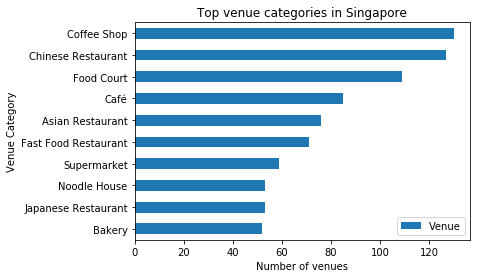

In [12]:
# DONT HAVE TO RUN EACH TIME!

#map bar chart of popular venues

sg_venues_sum4 = sg_venues_sum3.nlargest(10,'Venue')
sg_venues_sum5 = sg_venues_sum4.sort_values(by=['Venue'], ascending=True)

sg_venues_sum5.index = sg_venues_sum5.index.map(str) 
sg_venues_sum5.plot(kind='barh')

plt.title('Top venue categories in Singapore')
plt.ylabel('Venue Category')
plt.xlabel('Number of venues')

plt.show() # need this line to show the updates made to the figure


In [13]:
# explore how many venues per District

sg_districts_sum = sg_venues.groupby(["District"], as_index=False).count()
sg_districts_sum2 = sg_districts_sum.drop(columns=['Neighbourhood Latitude', 'Neighbourhood Longitude', 'Venue Category', 'Venue Latitude', 'Venue Longitude'])
sg_districts_sum3 = sg_districts_sum2.sort_values(by=['Venue'], ascending=False)
sg_districts_sum3.head(10)

,District,Venue
14,Marine Parade,100
9,Geylang,100
24,Tanglin,100
16,Outram,100
15,Novena,100
13,Kallang,100
8,Clementi,98
4,Bukit Merah,96
1,Bedok,95
27,Yishun,95


### Analyse spa locations

In [14]:
#get list of spas

sg_spa = sg_venues[sg_venues["Venue Category"]=='Spa']
sg_spa_sum = sg_spa.groupby(["District"], as_index=False).count()
sg_spa_sum2 = sg_spa_sum.drop(columns=['Neighbourhood Latitude', 'Neighbourhood Longitude', 'Venue Latitude', 'Venue Longitude','Venue Category'])
sg_spa_sum3 = sg_spa_sum2.sort_values(by=['Venue'], ascending=False)
sg_spa_sum3.head(30)

,District,Venue
1,Bishan,3
7,Tanglin,3
5,Outram,2
0,Ang Mo Kio,1
2,Bukit Merah,1
3,Bukit Timah,1
4,Kallang,1
6,Punggol,1


In [16]:
# map of spas

# create map of Singapore using latitude and longitude values
map_sg_spa = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for Latitude, Longitude, Venue in zip(sg_spa['Venue Latitude'], sg_spa['Venue Longitude'], sg_spa['Venue']):
    label = '{}'.format(Venue)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [Latitude, Longitude],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_sg_spa)
    
map_sg_spa

In [ ]:
## need to re-run to replace MAssage... with Spa?

### Prepare summary DF for neighbourhood analysis

In [17]:
#sg_venues.resetindex('Venue Category', inplace = True)

# one hot encoding
sg_onehot = pd.get_dummies(sg_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
sg_onehot['District'] = sg_venues['District'] 

# move neighborhood column to the first column
fixed_columns = [sg_onehot.columns[-1]] + list(sg_onehot.columns[:-1])
sg_onehot = sg_onehot[fixed_columns]

sg_onehot.head(100)

,District,Accessories Store,American Restaurant,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,...,Video Game Store,Video Store,Vietnamese Restaurant,Water Park,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Yoga Studio
0,Ang Mo Kio,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Ang Mo Kio,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Ang Mo Kio,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Ang Mo Kio,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Ang Mo Kio,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,Ang Mo Kio,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,Ang Mo Kio,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
7,Ang Mo Kio,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,Ang Mo Kio,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,Ang Mo Kio,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
sg_grouped = sg_onehot.groupby('District').mean().reset_index()
sg_grouped

,District,Accessories Store,American Restaurant,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,...,Video Game Store,Video Store,Vietnamese Restaurant,Water Park,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Yoga Studio
0,Ang Mo Kio,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.023256,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000
1,Bedok,0.000000,0.010526,0.000000,0.00,0.000000,0.00,0.000000,0.031579,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.010526,0.000000
2,Bishan,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.037500,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000
3,Bukit Batok,0.000000,0.022727,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,...,0.000000,0.022727,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000
4,Bukit Merah,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.041667,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.010417
5,Bukit Panjang,0.000000,0.025641,0.000000,0.00,0.000000,0.00,0.000000,0.076923,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000
6,Bukit Timah,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.015873,0.015873,0.000000,0.000000
7,Choa Chu Kang,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.025641,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000
8,Clementi,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.010204,0.040816,0.000000,...,0.010204,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000
9,Geylang,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.070000,0.000000,...,0.000000,0.000000,0.010000,0.000000,0.00,0.00,0.000000,0.000000,0.010000,0.000000


In [19]:
sg_grouped.shape

(28, 232)

In [20]:
# get top venues by district

num_top_venues = 5

for District in sg_grouped['District']:
    print("----"+District+"----")
    temp = sg_grouped[sg_grouped['District'] == District].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Ang Mo Kio----
                  venue  freq
0            Food Court  0.12
1    Chinese Restaurant  0.08
2           Coffee Shop  0.06
3  Fast Food Restaurant  0.05
4          Noodle House  0.03


----Bedok----
                  venue  freq
0           Coffee Shop  0.09
1            Food Court  0.07
2    Chinese Restaurant  0.07
3           Supermarket  0.05
4  Fast Food Restaurant  0.04


----Bishan----
                venue  freq
0  Chinese Restaurant  0.12
1              Bakery  0.08
2     Thai Restaurant  0.06
3                Café  0.06
4         Coffee Shop  0.05


----Bukit Batok----
                venue  freq
0  Italian Restaurant  0.07
1       Shopping Mall  0.05
2         Coffee Shop  0.05
3         Supermarket  0.05
4       Historic Site  0.05


----Bukit Merah----
                venue  freq
0  Chinese Restaurant  0.19
1          Food Court  0.07
2         Coffee Shop  0.07
3                Café  0.05
4        Noodle House  0.04


----Bukit Panjang----
                

In [21]:
# function to sort venues in descending order

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

#--------------


# top 10 venues for each borough

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['District']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['District'] = sg_grouped['District']

for ind in np.arange(sg_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(sg_grouped.iloc[ind, :], num_top_venues)

neighbourhoods_venues_sorted.head()

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Ang Mo Kio,Food Court,Chinese Restaurant,Coffee Shop,Fast Food Restaurant,Dessert Shop,Japanese Restaurant,Noodle House,Supermarket,Bar,Seafood Restaurant
1,Bedok,Coffee Shop,Food Court,Chinese Restaurant,Supermarket,Café,Fast Food Restaurant,Bakery,Noodle House,Sandwich Place,Asian Restaurant
2,Bishan,Chinese Restaurant,Bakery,Café,Thai Restaurant,Coffee Shop,Food Court,Spa,Asian Restaurant,Indian Restaurant,Ice Cream Shop
3,Bukit Batok,Italian Restaurant,Coffee Shop,Shopping Mall,Supermarket,Indian Restaurant,Thrift / Vintage Store,Café,Historic Site,Bus Stop,Bistro
4,Bukit Merah,Chinese Restaurant,Food Court,Coffee Shop,Café,Noodle House,Asian Restaurant,Bakery,Fast Food Restaurant,Bus Station,Hainan Restaurant


### Do clustering analysis

In [56]:
# DONT NEED TO RUN EVERY TIME! 


# set number of clusters
kclusters = 6

#put # infront of below line for first run?
sg_group_clusters = sg_grouped.drop('District', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(sg_group_clusters)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 1, 4, 3, 4, 1, 2, 5, 1, 1], dtype=int32)

In [58]:
# DONT NEED TO RUN EVERY TIME! 


# add clustering labels

#for repeating exercise with different k values, run below line
del neighbourhoods_venues_sorted['Cluster Labels']

neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

sg_merged = districtsgeo

neighbourhoods_venues_sorted['District'] = neighbourhoods_venues_sorted['District'].str.upper()

# merge sg_grouped with sg_data to add latitude/longitude for each neighborhood
sg_merged = sg_merged.join(neighbourhoods_venues_sorted.set_index('District'), on='District')

sg_merged.head() # check the last columns!

,District,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,ANG MO KIO,1.3691,103.8454,1,Food Court,Chinese Restaurant,Coffee Shop,Fast Food Restaurant,Dessert Shop,Japanese Restaurant,Noodle House,Supermarket,Bar,Seafood Restaurant
1,BEDOK,1.3236,103.9273,1,Coffee Shop,Food Court,Chinese Restaurant,Supermarket,Café,Fast Food Restaurant,Bakery,Noodle House,Sandwich Place,Asian Restaurant
2,BISHAN,1.3526,103.8352,4,Chinese Restaurant,Bakery,Café,Thai Restaurant,Coffee Shop,Food Court,Spa,Asian Restaurant,Indian Restaurant,Ice Cream Shop
3,BUKIT BATOK,1.3590,103.7637,3,Italian Restaurant,Coffee Shop,Shopping Mall,Supermarket,Indian Restaurant,Thrift / Vintage Store,Café,Historic Site,Bus Stop,Bistro
4,BUKIT MERAH,1.2819,103.8239,4,Chinese Restaurant,Food Court,Coffee Shop,Café,Noodle House,Asian Restaurant,Bakery,Fast Food Restaurant,Bus Station,Hainan Restaurant


In [59]:
# DONT NEED TO RUN EVERY TIME! 


# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(sg_merged['Latitude'], sg_merged['Longitude'], sg_merged['District'], sg_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Load data sets from Data.gov.sg

### Get list of income by district - OK!

In [22]:
# get data from SG website for wealth
# Singapore Residents by Planning Area, Subzone, Age Group, Sex and Type of Dwelling, June 2011-2019

url = 'https://data.gov.sg/api/action/datastore_search?resource_id=####### REMOVED ######## &limit=500000'

results = requests.get(url).json()

# assign relevant part of JSON to venues
demographics1 = results['result']['records']

# tranform venues into a dataframe
df_sg_dem1 = json_normalize(demographics1)

#rename columns
df_sg_dem1.columns=['ID', 'Income', 'TOTAL', 'District','Population','Year']

df_sg_dem1.head()

,ID,Income,TOTAL,District,Population,Year
0,1,Total,Total,Ang Mo Kio,101.2,2015
1,2,Total,Total,Bedok,150.3,2015
2,3,Total,Total,Bishan,49.5,2015
3,4,Total,Total,Bukit Batok,75.6,2015
4,5,Total,Total,Bukit Merah,82.2,2015


In [23]:
#group by income band

sg_dem2 = df_sg_dem1
sg_dem2["Population"] = pd.to_numeric(sg_dem2["Population"])
sg_dem3 = sg_dem2.groupby(["Income"], as_index=False).agg({"Population": "sum"})

# add median income column

income_med = ['1250', '1750', '10500', '11500', '12500', '2250', '2750', '3500', '4500', '5500', '6500', '7500', '8500', '9500', '500', '0']
sg_dem3 ["income_med"] = income_med
sg_dem3 ["income_med"] = pd.to_numeric(sg_dem3["income_med"])


sg_dem3 = sg_dem3.sort_values(by=['income_med'], ascending=True)

# remove TOTAL line
sg_dem3 = sg_dem3[sg_dem3.Income != 'Total']


print(sg_dem3)

               Income  Population  income_med
14       Below $1,000       173.5         500
0     $1,000 - $1,499       184.9        1250
1     $1,500 - $1,999       148.8        1750
5     $2,000 - $2,499       160.4        2250
6     $2,500 - $2,999       137.1        2750
7     $3,000 - $3,999       269.2        3500
8     $4,000 - $4,999       217.9        4500
9     $5,000 - $5,999       178.8        5500
10    $6,000 - $6,999       132.7        6500
11    $7,000 - $7,999       103.5        7500
12    $8,000 - $8,999        84.9        8500
13    $9,000 - $9,999        60.2        9500
2   $10,000 - $10,999        57.5       10500
3   $11,000 - $11,999        36.5       11500
4      $12,000 & Over       205.3       12500


In [24]:
#drop income column and index, and reorder columns
sg_dem4 = sg_dem3 [['income_med', 'Population']]
sg_dem4 = sg_dem4.set_index('income_med')

print(sg_dem4)

            Population
income_med            
500              173.5
1250             184.9
1750             148.8
2250             160.4
2750             137.1
3500             269.2
4500             217.9
5500             178.8
6500             132.7
7500             103.5
8500              84.9
9500              60.2
10500             57.5
11500             36.5
12500            205.3


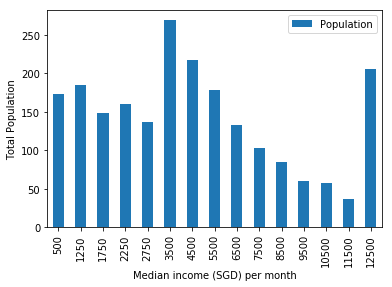

In [25]:
#map bar chart of incomes

sg_dem4.plot(kind='bar')

#plt.title('Top venue categories in Singapore')
plt.ylabel('Total Population')
plt.xlabel('Median income (SGD) per month')

plt.show() # need this line to show the updates made to the figure

In [26]:
# show population by district

sg_dem5=df_sg_dem1.drop(columns=['ID', 'TOTAL','Year']) 
sg_dem5.head()

,Income,District,Population
0,Total,Ang Mo Kio,101.2
1,Total,Bedok,150.3
2,Total,Bishan,49.5
3,Total,Bukit Batok,75.6
4,Total,Bukit Merah,82.2


In [27]:
#show mapping of income band to median

sg_inc_map = sg_dem3.drop(columns=['Population'])
sg_inc_map.head()

,Income,income_med
14,"Below $1,000",500
0,"$1,000 - $1,499",1250
1,"$1,500 - $1,999",1750
5,"$2,000 - $2,499",2250
6,"$2,500 - $2,999",2750


In [28]:
# make new table with average income by district

# merge dfs

sg_dem6 = pd.merge(sg_dem5, sg_inc_map, on='Income')

# remove TOTAL line
sg_dem6 = sg_dem6[sg_dem6.Income != 'Total']
sg_dem6 = sg_dem6.drop(columns=['Income'])

#sumproduct, sum, then divide for weighted average

sg_dem6["sum_prod"] = sg_dem6["Population"] * sg_dem6 ["income_med"]

sg_avg_inc = sg_dem6.groupby(["District"], as_index=False).agg({"Population": "sum","sum_prod": "sum"})

sg_avg_inc["avg_inc"] = sg_avg_inc["sum_prod"] / sg_avg_inc ["Population"]

sg_avg_inc = sg_avg_inc.drop(columns=['sum_prod'])

sg_avg_inc['District'] = sg_avg_inc['District'].str.upper()

sg_avg_inc.head()

,District,Population,avg_inc
0,ANG MO KIO,101.3,4615.498519
1,BEDOK,150.3,5206.586826
2,BISHAN,49.6,5967.741935
3,BUKIT BATOK,75.7,5068.692206
4,BUKIT MERAH,82.1,4792.021924


### FUTURE EXERCISE: Get list of age group, sex and house size etc. by district

In [30]:
# Dropped from scope

body = client_3ab866f0d9c448a782d08384f881ae8d.get_object(Bucket='ibmdatasciencecapstoneproject-donotdelete-pr-5sqxsnewnajpl8',Key='planning-area-subzone-age-group-sex-and-type-of-dwelling-june-2011-2019.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_1 = pd.read_csv(body)

df_data_1.columns=['District', 'Subzone', 'Age Group', 'Sex','Dwelling Type', 'Count', 'Year']

print(df_data_1.shape)
df_data_1.head()

(883728, 7)


,planning_area,subzone,age_group,sex,type_of_dwelling,resident_count,year
0,Ang Mo Kio,Ang Mo Kio Town Centre,0_to_4,Males,HDB 1- and 2-Room Flats,0,2011
1,Ang Mo Kio,Ang Mo Kio Town Centre,0_to_4,Males,HDB 3-Room Flats,10,2011
2,Ang Mo Kio,Ang Mo Kio Town Centre,0_to_4,Males,HDB 4-Room Flats,30,2011
3,Ang Mo Kio,Ang Mo Kio Town Centre,0_to_4,Males,HDB 5-Room and Executive Flats,50,2011
4,Ang Mo Kio,Ang Mo Kio Town Centre,0_to_4,Males,HUDC Flats (excluding those privatised),0,2011


In [ ]:
# TO DO: filter just for totals in subzone (use code up above), calculate average age,
# TO DO: see % male / female by district
# TO DO: most popular house type by district - is there a link?

### Chloropleth map set up - GEOJSON

In [29]:
# Bring in file from Watson assets

# @hidden_cell
# The following code contains the credentials for a file in your IBM Cloud Object Storage.
# You might want to remove those credentials before you share your notebook.
credentials_1 = {
    '###### CREDENTIALS REMOVED #######
    'BUCKET': 'ibmdatasciencecapstoneproject-donotdelete-pr-5sqxsnewnajpl8',
    'FILE': 'MP14_PLNG_AREA_NO_SEA_PL.geojson'
}


In [30]:

# Your data file was loaded into a botocore.response.StreamingBody object.
# Please read the documentation of ibm_boto3 and pandas to learn more about the possibilities to load the data.
# ibm_boto3 documentation: https://ibm.github.io/ibm-cos-sdk-python/
# pandas documentation: http://pandas.pydata.org/
streaming_body_1 = client_##### REMOVED ######## .get_object(Bucket='ibmdatasciencecapstoneproject-donotdelete-pr-5sqxsnewnajpl8', Key='sg_planning_areas.geojson')['Body']
# add missing __iter__ method so pandas accepts body as file-like object
if not hasattr(streaming_body_1, "__iter__"): streaming_body_1.__iter__ = types.MethodType( __iter__, streaming_body_1 ) 


In [31]:
from ibm_botocore.client import Config
import ibm_boto3
cos = ibm_boto3.client(service_name='s3',
    ibm_api_key_id=credentials_1['IBM_API_KEY_ID'],
    ibm_service_instance_id=credentials_1['IAM_SERVICE_ID'],
    ibm_auth_endpoint=credentials_1['IBM_AUTH_ENDPOINT'],
    config=Config(signature_version='oauth'),
    endpoint_url=credentials_1['ENDPOINT'])

In [32]:
any_name = cos.get_object(Bucket= credentials_1['BUCKET'], Key='sg_planning_areas.geojson')['Body']
sg_ura_geo = json.load(any_name)

In [33]:
# Make Singapore geo coordinates upper case

districtsgeo2 = districtsgeo
districtsgeo2['District'] = districtsgeo2['District'].str.upper()
districtsgeo2.head()

,District,Latitude,Longitude
0,ANG MO KIO,1.3691,103.8454
1,BEDOK,1.3236,103.9273
2,BISHAN,1.3526,103.8352
3,BUKIT BATOK,1.3590,103.7637
4,BUKIT MERAH,1.2819,103.8239


In [34]:
# To update the dataframe (sg spa 3) and columns. check DV lab 
# key_on='feature.properties.name' was original but maybe replace whole thing with pln_area_n?
map_sg_chl = folium.Map(location=[latitude, longitude], zoom_start=12)

map_sg_chl.choropleth(
    geo_data=sg_ura_geo,
    data=sg_avg_inc,
    columns=['District', 'avg_inc'],
    key_on='feature.properties.PLN_AREA_N',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Venues in SG'
)

# display map
map_sg_chl

/home/dsxuser/.local/lib/python3.6/site-packages/folium/folium.py:413: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


### Look at linear regression - simple and multi-

In [40]:
# make new table with average income by district

# Do left join, so zero where zero spas

sg_spa_sum3['District'] = sg_spa_sum3['District'].str.upper()

# merge dfs

sg_spa_reg = pd.merge(sg_avg_inc, sg_spa_sum3, on='District', how = 'left')

sg_spa_reg['Venue'] = sg_spa_reg['Venue'].fillna(0)

sg_spa_reg.rename(columns={'Venue':'Spa_Count'})

print(sg_spa_reg)


         District  Population      avg_inc  Venue
0      ANG MO KIO       101.3  4615.498519    1.0
1           BEDOK       150.3  5206.586826    0.0
2          BISHAN        49.6  5967.741935    3.0
3     BUKIT BATOK        75.7  5068.692206    0.0
4     BUKIT MERAH        82.1  4792.021924    1.0
5   BUKIT PANJANG        80.0  4901.562500    0.0
6     BUKIT TIMAH        36.9  8113.143631    1.0
7   CHOA CHU KANG        97.4  4794.404517    0.0
8        CLEMENTI        46.2  5646.645022    0.0
9         GEYLANG        61.2  4667.892157    0.0
10        HOUGANG       120.7  4711.060481    0.0
11    JURONG EAST        46.1  4629.067245    0.0
12    JURONG WEST       158.5  4468.138801    0.0
13        KALLANG        55.3  5020.795660    1.0
14  MARINE PARADE        21.6  6359.953704    0.0
15         NOVENA        23.6  6452.330508    0.0
16         OTHERS        21.5  6781.395349    0.0
17         OUTRAM        11.5  4789.130435    2.0
18      PASIR RIS        77.9  5233.632863    0.0


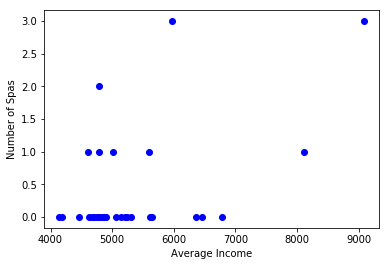

In [44]:
# Plot to see correlation of income

plt.scatter(sg_spa_reg.avg_inc, sg_spa_reg.Venue,  color='blue')
plt.xlabel("Average Income")
plt.ylabel("Number of Spas")
plt.show()

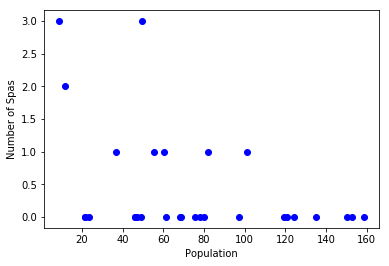

In [43]:
# Plot to see correlation of population 

plt.scatter(sg_spa_reg.Population, sg_spa_reg.Venue,  color='blue')
plt.xlabel("Population")
plt.ylabel("Number of Spas")
plt.show()

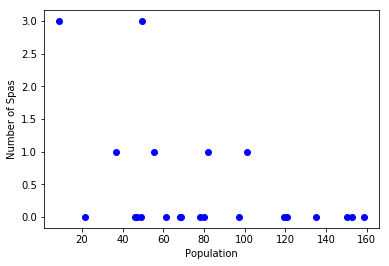

In [45]:
# create train and test data

msk = np.random.rand(len(sg_spa_reg)) < 0.8
train = sg_spa_reg[msk]
test = sg_spa_reg[~msk]

#Train data distribution (ML0101)

plt.scatter(train.Population, train.Venue,  color='blue')
plt.xlabel("Population")
plt.ylabel("Number of Spas")
plt.show()

In [46]:
# model data

from sklearn import linear_model
regr = linear_model.LinearRegression()
train_x = np.asanyarray(train[['Population']])
train_y = np.asanyarray(train[['Venue']])
regr.fit (train_x, train_y)
# The coefficients
print ('Coefficients: ', regr.coef_)
print ('Intercept: ',regr.intercept_)

Coefficients:  [[-0.00927594]]
Intercept:  [1.2084688]


Text(0, 0.5, 'Number of Spas')

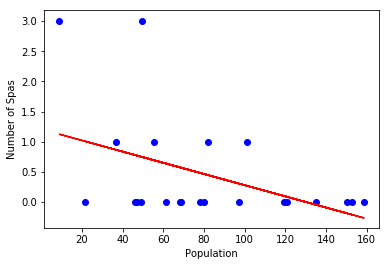

In [47]:
# plot output

plt.scatter(train.Population, train.Venue,  color='blue')
plt.plot(train_x, regr.coef_[0][0]*train_x + regr.intercept_[0], '-r')
plt.xlabel("Population")
plt.ylabel("Number of Spas")

In [48]:
# score

from sklearn.metrics import r2_score

test_x = np.asanyarray(test[['Population']])
test_y = np.asanyarray(test[['Venue']])
test_y_hat = regr.predict(test_x)

print("Mean absolute error: %.2f" % np.mean(np.absolute(test_y_hat - test_y)))
print("Residual sum of squares (MSE): %.2f" % np.mean((test_y_hat - test_y) ** 2))
print("R2-score: %.2f" % r2_score(test_y_hat , test_y) )

Mean absolute error: 0.66
Residual sum of squares (MSE): 0.54
R2-score: -3.75


In [ ]:
Mean absolute error: It is the mean of the absolute value of the errors. This is the easiest of the metrics to understand since it’s just average error.
Mean Squared Error (MSE): Mean Squared Error (MSE) is the mean of the squared error. It’s more popular than Mean absolute error because the focus is geared more towards large errors. This is due to the squared term exponentially increasing larger errors in comparison to smaller ones.
Root Mean Squared Error (RMSE): This is the square root of the Mean Square Error.
R-squared is not error, but is a popular metric for accuracy of your model. It represents how close the data are to the fitted regression line. The higher the R-squared, the better the model fits your data. Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse).